In [11]:
# https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")


In [12]:
# load data
sales = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/sales_train.csv')

# settings
import warnings
warnings.filterwarnings('ignore')

item_cat = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/item_categories.csv')
item = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/items.csv')
sub = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/sample_submission.csv')
shops = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/shops.csv')
test = pd.read_csv('Desktop/Python/Kaggle/Predict Future Sales/test.csv')

In [13]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [14]:
# formatting the date column correctly
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [20]:
# Aggregate to monthly level the required metrics
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['date','item_price','item_cnt_day'].agg({'date':['min', 'max'],'item_price':'mean', 'item_cnt_day':'sum'})
## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [21]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

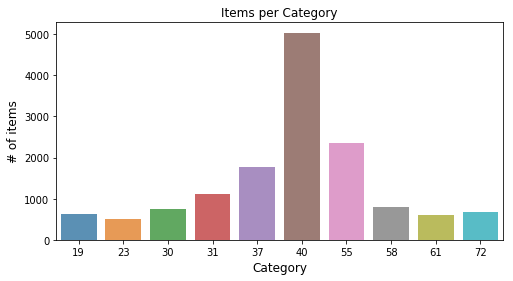

In [26]:
# number of items per cat
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.iloc[0:10].reset_index()
x

# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title('Items per Category')
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

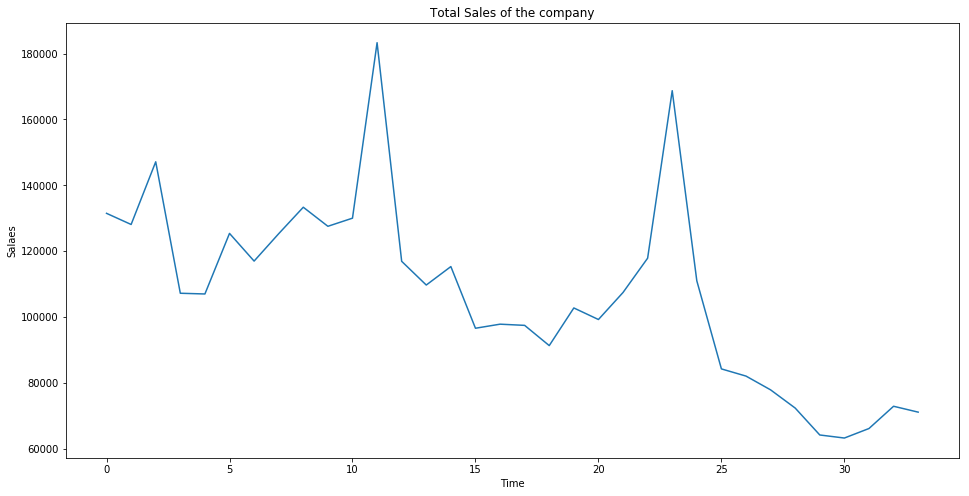

In [31]:
# single series
# First let's compute the total sales per month and plot that data.
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Salaes')
plt.plot(ts);

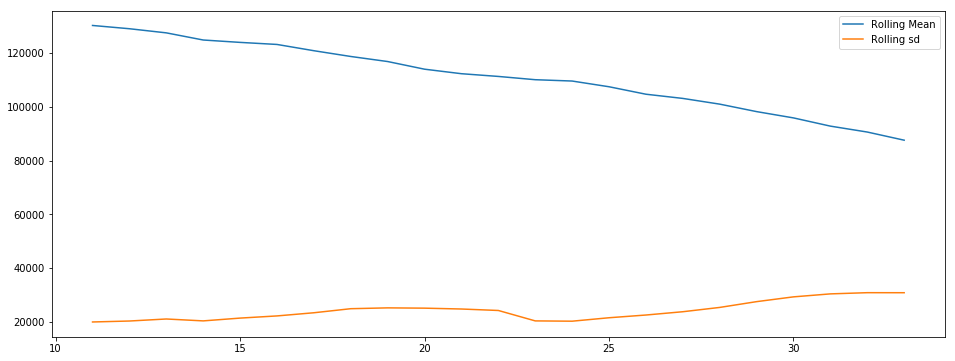

In [32]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean');
plt.plot(ts.rolling(window=12, center=False).std(), label='Rolling sd');
plt.legend();

In [33]:
# Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".
# Let's check that with a quick decomposition into Trend, seasonality and residuals.

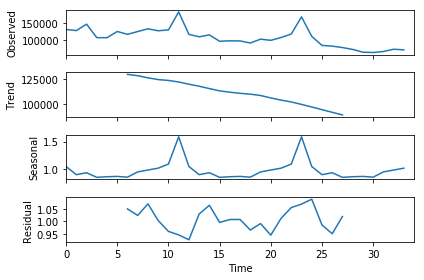

In [34]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model='multiplicative')
# plot.figure(figsize=(16,12))
fig = res.plot()
# fig.show()

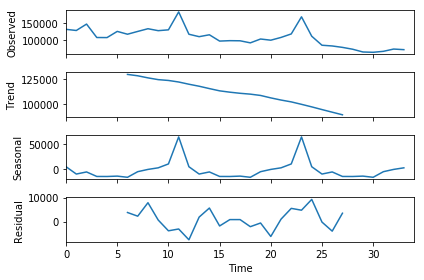

In [35]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='additive')
#plt.figure(figsize=(16,12))
fig = res.plot()
# fig.show()

In [36]:
# yt=St+Tt+Et
# where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model

In [37]:
# Stationarity tests
def test_stationarity(timeseries):
    # perform dickey-fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                            '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [38]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

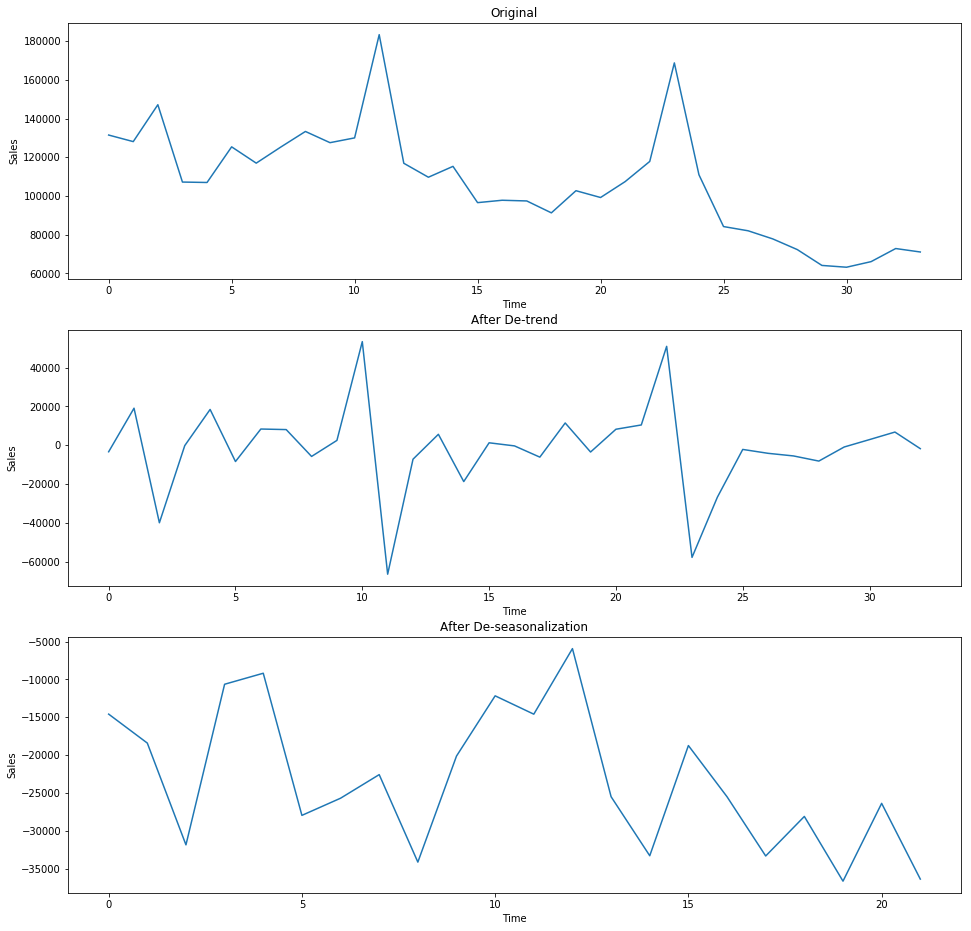

In [39]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts,12) # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [40]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [42]:
# Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series
# MA - Next value in the series is a function of the average of the previous n number of values AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values ARMA - a mixture of both.

In [45]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return
        

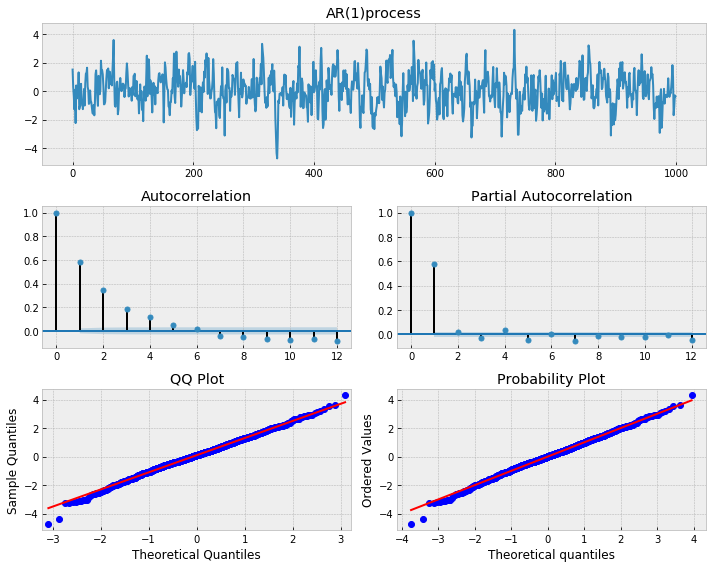

In [46]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit = 12
_ = tsplot(x, lags=limit, title='AR(1)process')

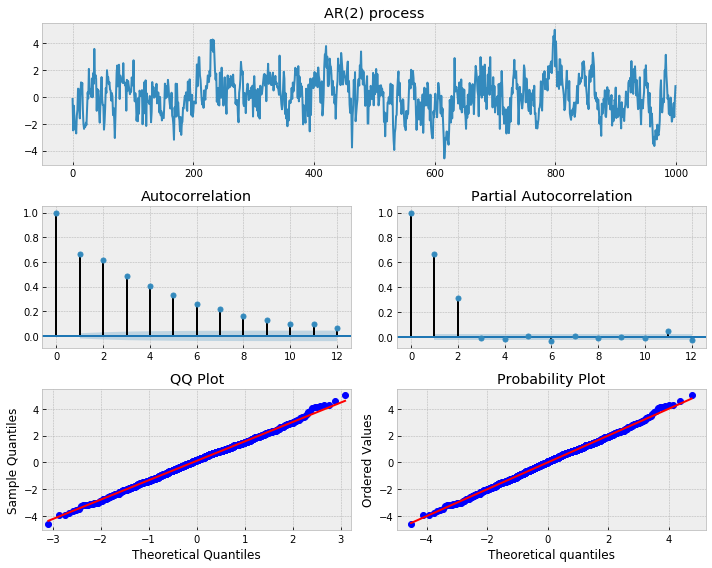

In [47]:
# AR(1) process -- has ACF tailing out and PACF cutting off at lag = 1
# simulate an AR(2) process

n = int(1000)
alphas = np.array([.444,.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org

ar = np.r_[1,-alphas]
ma = np.r_[1,betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ar2, lags=12, title='AR(2) process')

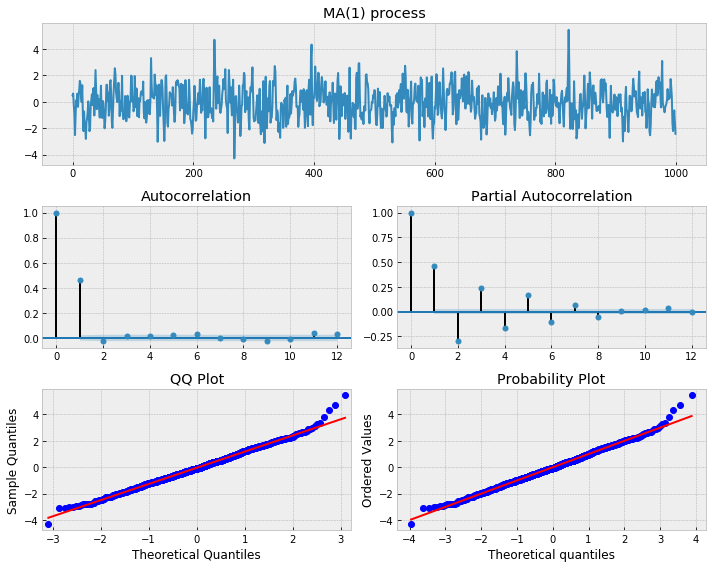

In [48]:
# AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
mal = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit=12
_ = tsplot(mal, lags=limit, title='MA(1) process')

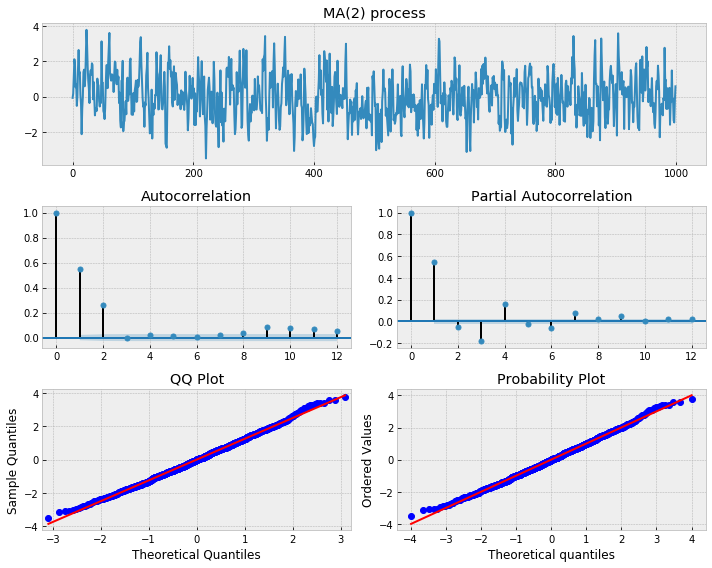

In [49]:
# MA(1) process -- has ACF cut off at lag=1
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12, title='MA(2) process')

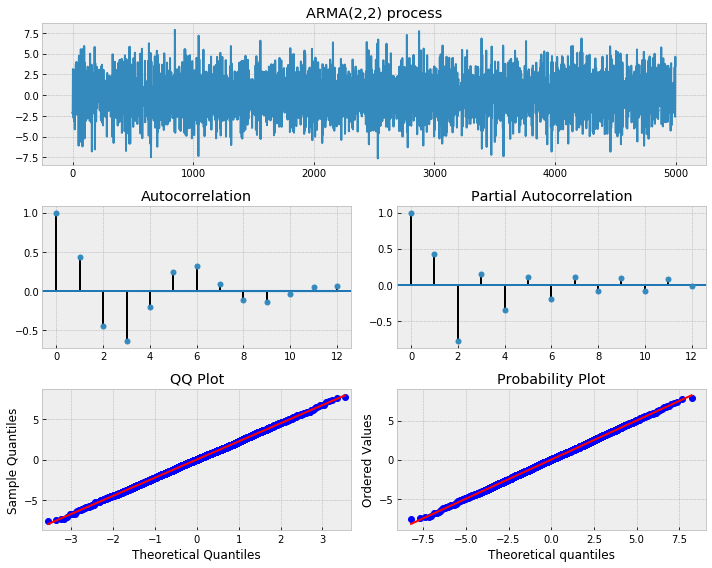

In [50]:
# MA(2) process -- has ACF cut off at lag=2
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin = burn)
_ = tsplot(arma22, lags=max_lag, title='ARMA(2,2) process')

In [51]:
# Let's use a systematic approach to finding the order of AR and MA processes.¶

In [52]:
# pick best order by aic
# smallest aic value wins
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


In [53]:
# We've correctly identified the order of the simulated process as ARMA(2,2).

In [54]:
# pick best order by aic
# smallest aic value wins
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order:{}'.format(best_aic, best_order))

aic: 472.99703 | order:(1, 1)


In [55]:
# Simply use best_mdl.predict() to predict the next values
# adding the dates to the Time-series as index
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.index = pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS')
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [57]:
# At its core, the Prophet procedure is an additive regression model with four main components:
# A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
# A yearly seasonal component modeled using Fourier series.
# A weekly seasonal component using dummy variables.
# A user-provided list of important holidays.

from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns = ['ds', 'y']
model = Prophet(yearly_seasonality=True) # instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) # fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# predict for five months in the future and MS - month start is the frequency
future = model.make_future_dataframe(periods=5, freq='MS')
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,82148.114207,79122.172347,85194.554197
35,2015-12-01,127824.821967,124857.152515,130857.817635
36,2016-01-01,77028.927356,73975.036020,80000.779148
37,2016-02-01,40725.953288,37776.889413,43761.254650
38,2016-03-01,78632.924570,75726.717549,81595.750372


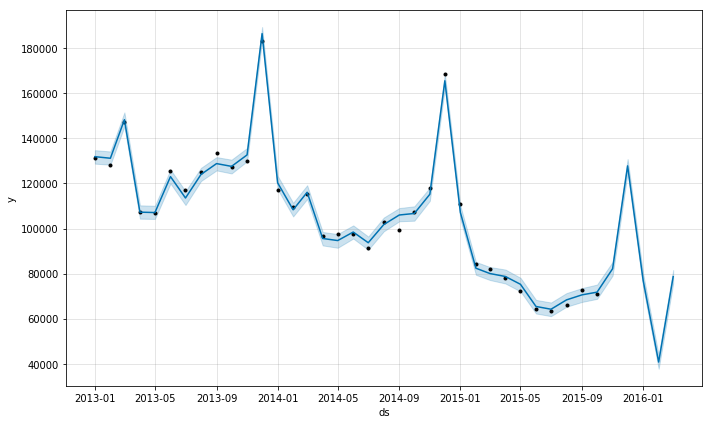

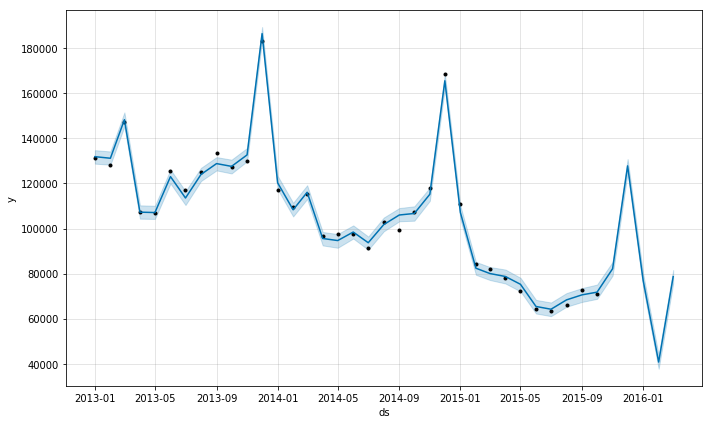

In [60]:
model.plot(forecast)

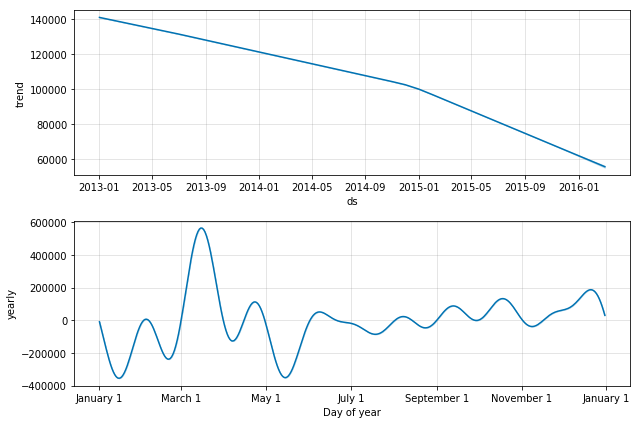

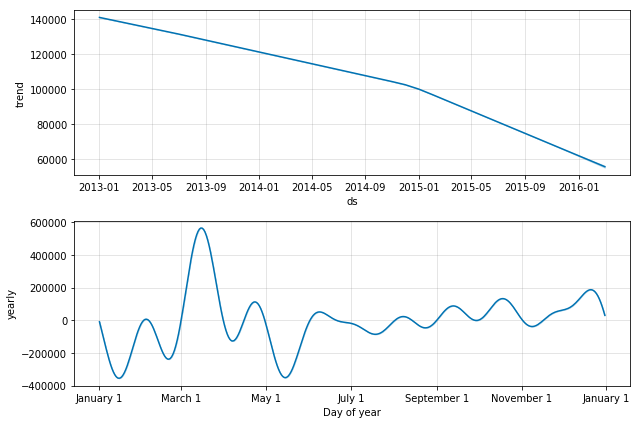

In [61]:
model.plot_components(forecast)

In [62]:
# Unobserved Components Model. The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.

In [63]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
dates = pd.date_range(start = '2013-01-01', end='2015-10-01', freq='MS')

total_sales.index = dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [85]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum()
# arrange it conviniently to perform the hts
monthly_sales = monthly_sales.unstack(level=-1).fillna(0)
monthly_sales = monthly_sales.T
dates = pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS')
monthly_sales.index = dates
monthly_sales = monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...   \
item_id               30    31    32   33    35   36   40   42   43  ...    
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...    
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...    
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [90]:
import time
start_time = time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py

forecastDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis=1)
    #     print(nodeToForecast.head())  # just to check
    # rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns={nodeToForecast.columns[0]:'ds'})
    nodeToForecast = nodeToForecast.rename(columns={nodeToForecast.columns[1]:'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods=1, freq='MS')
    forecastDict[node] = m.predict(future)
    if (node==10):
        end_time = time.time()
        print('forecasting for ', node,'th node and took',end_time-start_time, 's')
        break

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

forecasting for  10 th node and took 22.33880591392517 s


In [91]:
# As we need a million predictions. This would not work out

In [102]:
# Middle out
# Let's predict for the store level
monthly_shop_sales = sales.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum()
# get the shops to the columns
monthly_shop_sales = monthly_shop_sales.unstack(level=1)
monthly_shop_sales = monthly_shop_sales.fillna(0)
monthly_shop_sales.index = dates
monthly_shop_sales = monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [103]:
start_time = time.time()
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0],
                               monthly_shop_sales.iloc[:, node+1]], axis=1)
    #     print(nodeToForecast.head())  # just to check
    # rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns={nodeToForecast.columns[0]:'ds'})
    nodeToForecast = nodeToForecast.rename(columns={nodeToForecast.columns[1]:'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods=1,freq='MS')
    forecastDict[node] = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

In [115]:
# predictions = np.zeros([len(forecastDict[0].yhat), 1])
nCols = len(list(forecastDict.keys())) + 1
for key in range(0, nCols-1):
    f1 = np.array(forecastDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
        # print(predictions.shape)
    else:
        predictions = np.concatenate((predictions, f2), axis=1)

In [116]:
predictions_unknown=predictions[-1]
predictions_unknown

array([-766.52643677, -465.85915791, 1113.70947269,  849.88275161,
        984.35892057, 1414.68796599, 2258.95215421, 1811.2092623 ,
       -330.52620849, -254.61038098,  564.0950296 ,   21.91173344,
       4406.40434602, -333.48819275, 1300.06228279, 1829.77851254,
       1007.06140596,  924.28146141,  847.34730744, 1805.6884215 ,
       -681.46089581, 2146.29308984, 1412.50443481, -655.29371789,
       1680.87704765, 6706.50568069, 1367.56290582, 3442.76378736,
       4218.77413371,  738.85041622,  395.68117545, 8029.42218946,
       -712.98579872,  566.27470302])